In [1]:
import nltk

In [2]:
# The punkt module is a pre-trained model that helps you tokenize words and sentences.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [5]:
import string
mess = 'Sample message! Notice: it has punctuation.'
# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]
# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [6]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [7]:
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

In [8]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc) 
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in set(all_stopwords)]

In [9]:
import pandas as pd
df=pd.read_csv("/content/drive/My Drive/NLP/Whatsapp status emotion prediction/emotion.csv")
df.head(2)

,content,sentiment
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angry
1,Not available for busy people☺,angry


In [10]:
# Check to make sure its working
df['content'].head(5).apply(text_process)

0    [Sometimes, I’m, not, angry, I’m, hurt, there’...
1                      [Not, available, busy, people☺]
2    [not, exist, impress, world, exist, live, life...
3    [Everything, getting, expensive, except, peopl...
4                 [phone, screen, brighter, future, 🙁]
Name: content, dtype: object

In [11]:
df['length'] = df['content'].apply(len)
df.head(3)

,content,sentiment,length
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angry,63
1,Not available for busy people☺,angry,30
2,I do not exist to impress the world. I exist t...,angry,94


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['content'])
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

3501


In [13]:
df.describe()

,length
count,2039.000000
mean,1248.444826
std,3319.328614
min,7.000000
25%,54.000000
50%,72.000000
75%,101.000000
max,11817.000000


In [15]:
df.groupby('sentiment').describe()

length                                                             
           count         mean          std   min   25%   50%     75%      max
sentiment                                                                    
angry      696.0  1257.882184  2891.844135  18.0  55.0  74.0  108.00   8312.0
happy      708.0    70.464689    29.807400   7.0  49.0  65.5   87.25    275.0
sad        635.0  2551.502362  4795.684435  18.0  57.0  80.0  128.50  11817.0

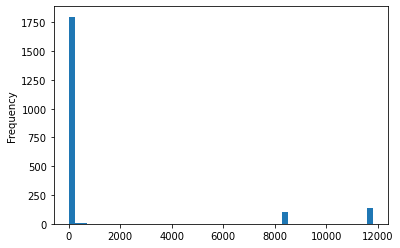

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
df['length'].plot(bins=50, kind='hist') 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa145f56a0>,
      dtype=object)

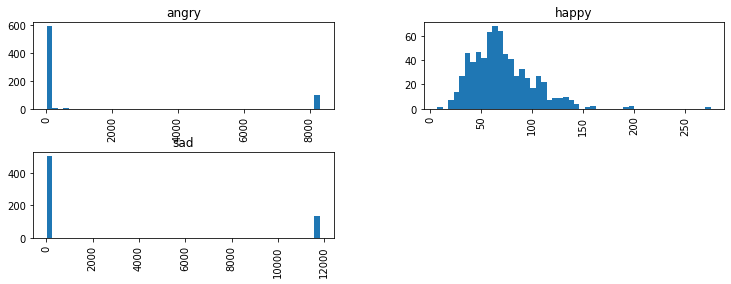

In [17]:
df.hist(column='length', by='sentiment', bins=50,figsize=(12,4))

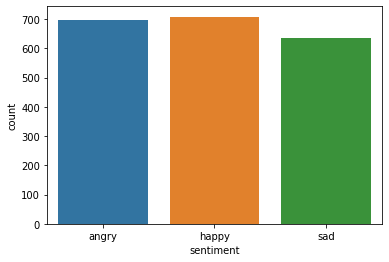

In [18]:
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.countplot(x ='sentiment', data = df) 
plt.show() 

In [19]:
message4 = df['content'][3]
print(message4)

Everything is getting expensive except some people, they are getting cheaper.


In [20]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 374)	1
  (0, 1580)	1
  (0, 1912)	1
  (0, 1925)	1
  (0, 2088)	2
  (0, 2656)	1
(1, 3501)


In [21]:
messages_bow = bow_transformer.transform(df['content'])

In [22]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (2039, 3501)
Amount of Non-Zero occurences:  115236


In [23]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 2


In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 2656)	0.21772366070494964
  (0, 2088)	0.6670522607225847
  (0, 1925)	0.3878565088772852
  (0, 1912)	0.3878565088772852
  (0, 1580)	0.415724819875675
  (0, 374)	0.18424228672188983


In [25]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(2039, 3501)


In [26]:
from sklearn.naive_bayes import MultinomialNB
detect_model = MultinomialNB().fit(messages_tfidf, df['sentiment'])

In [27]:
print('predicted:', detect_model.predict(tfidf4)[0])
print('expected:', df.sentiment[3])

predicted: angry
expected: angry


In [28]:
all_predictions =detect_model.predict(messages_tfidf)
print(all_predictions)

['angry' 'angry' 'happy' ... 'sad' 'happy' 'sad']


In [29]:
from sklearn.metrics import classification_report
print (classification_report(df['sentiment'], all_predictions))

              precision    recall  f1-score   support

       angry       0.96      0.88      0.92       696
       happy       0.75      0.97      0.85       708
         sad       0.94      0.72      0.81       635

    accuracy                           0.86      2039
   macro avg       0.88      0.86      0.86      2039
weighted avg       0.88      0.86      0.86      2039



In [30]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = \
train_test_split(df['content'], df['sentiment'], test_size=0.2)
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

1631 408 2039


In [31]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [32]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7ffa15225598>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [33]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

       angry       0.69      0.81      0.74       126
       happy       0.82      0.61      0.70       198
         sad       0.51      0.69      0.59        84

    accuracy                           0.69       408
   macro avg       0.67      0.70      0.68       408
weighted avg       0.72      0.69      0.69       408



In [34]:
t="mind say move on"

In [35]:
message4 ='mind say move on but heart say hold on'
print(message4)
bow4 = bow_transformer.transform([message4])
tfidf4 = tfidf_transformer.transform(bow4)
print('predicted:', detect_model.predict(tfidf4)[0])


mind say move on but heart say hold on
predicted: happy


In [36]:
message4 ="it was a beautiful"
print(message4)
bow4 = bow_transformer.transform([message4])
tfidf4 = tfidf_transformer.transform(bow4)
print('predicted:', detect_model.predict(tfidf4)[0])


it was a beautiful
predicted: happy


In [37]:
message4 ='she had sad eyes'
print(message4)
bow4 = bow_transformer.transform([message4])
tfidf4 = tfidf_transformer.transform(bow4)
print('predicted:', detect_model.predict(tfidf4)[0])


she had sad eyes
predicted: sad


In [38]:
message4 ="she gave her companion an angry glance"
print(message4)
bow4 = bow_transformer.transform([message4])
tfidf4 = tfidf_transformer.transform(bow4)
print('predicted:', detect_model.predict(tfidf4)[0])


she gave her companion an angry glance
predicted: angry
